


# **1. Import Libraries**






In [ ]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,LambdaCallback
from keras.layers import Input,Dropout, Dense,GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential,Model
from tensorflow.keras.layers import Input, UpSampling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
import numpy as np
import itertools
import datetime
import pandas as pd
import cv2
import os
import io

# **2. Load Data**

**2-1. Connect To Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**2-2. Unzip Dataset**

In [ ]:
# from zipfile import ZipFile

# with ZipFile('drive/MyDrive/brain_dataset.zip', 'r') as zipOb:
#   zipOb.extractall('drive/MyDrive/brain_tumor_dataset')

**2-3. Loading and Resizing**

In [ ]:
labels = []

X_train = []
y_train = []
X_test = []
y_test = []


trainPath = 'drive/MyDrive/brain_tumor_dataset'+'/Training/'
testPath = 'drive/MyDrive/brain_tumor_dataset'+'/Testing/'


for folder in os.listdir(trainPath):
    labels.append(folder)


for i in labels:
    labelPath = os.path.join(trainPath,i)
    for j in os.listdir(labelPath):
        img = cv2.imread(os.path.join(labelPath,j))
        img = cv2.resize(img,(128, 128))
        X_train.append(img)
        y_train.append(i)


for i in labels:
    labelPath = os.path.join(testPath,i)
    for j in os.listdir(labelPath):
        img = cv2.imread(os.path.join(labelPath,j))
        img = cv2.resize(img,(128, 128))
        X_test.append(img)
        y_test.append(i)

**2-4. Converting Lists to NumPy Arrays and Rescaling Pixel Values**

In [ ]:
# python list to numpy array
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

# rescaling
X_train=X_train/255.0
X_test=X_test/255.0

**2-5. Checking Shape of NumPy Arrays**

In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5712, 128, 128, 3) (5712,)
(1311, 128, 128, 3) (1311,)


**2-6. Visualizing Random Samples from the Dataset**

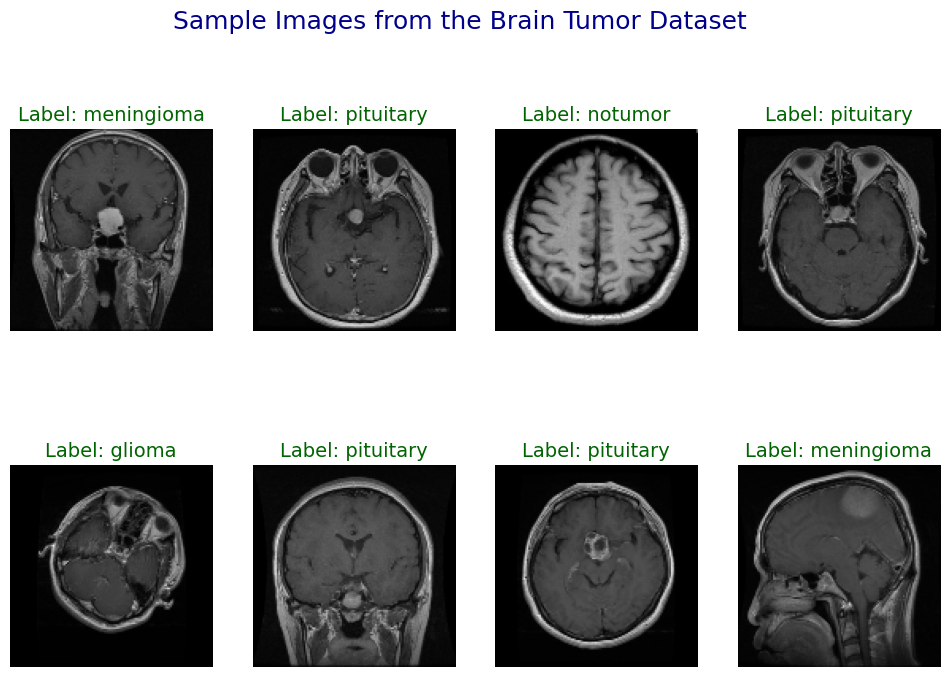

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Display sample images from the training set
fig, axes = plt.subplots(2, 4, figsize=(12, 8))
fig.suptitle('Sample Images from the Brain Tumor Dataset', fontsize=18, color='darkblue')

for i in range(2):
    for j in range(4):
        random_index = np.random.randint(0, len(X_train))
        ax = axes[i, j]
        ax.imshow(X_train[random_index], cmap='plasma')  # Use a colormap for better visualization
        ax.set_title(f'Label: {y_train[random_index]}', fontsize=14, color='darkgreen')
        ax.axis('off')
plt.show()


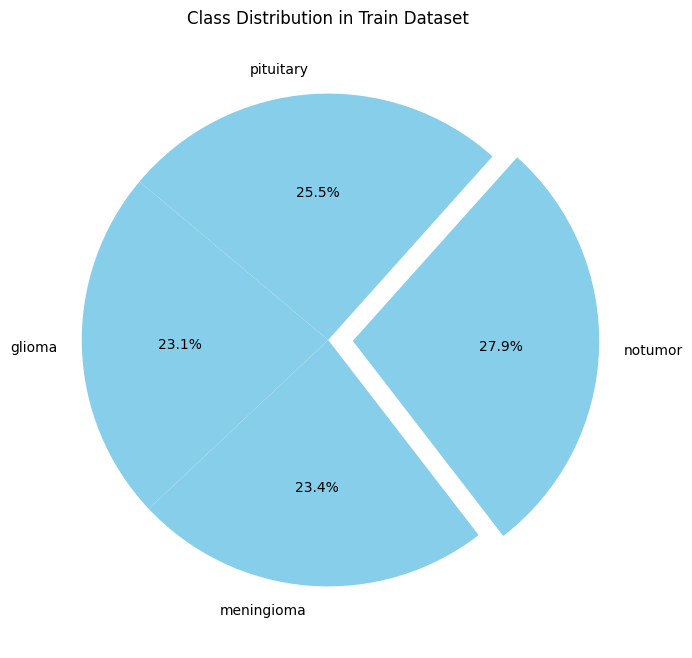

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_class_distribution_pie(labels, dataset_name):
    unique_labels, label_counts = np.unique(labels, return_counts=True)

    plt.figure(figsize=(8, 8))
    colors = ['skyblue'] * len(unique_labels)  # Set all parts to the same color

    # Find the index of the largest slice
    explode = [0.1 if count == max(label_counts) else 0 for count in label_counts]

    # Set the border width for each wedge
    wedgeprops = {'linewidth': 2}

    plt.pie(label_counts, labels=unique_labels, autopct='%1.1f%%', startangle=140, colors=colors, explode=explode, wedgeprops=wedgeprops)
    plt.title(f'Class Distribution in {dataset_name} Dataset')
    plt.show()

# Example usage
# Replace the placeholder below with your actual dataset and labels
plot_class_distribution_pie(y_train, "Train")


This pie chart visually represents the distribution of classes in the training dataset, helping to understand the balance or imbalance of class labels.

# **3. Data Preparation Pipeline: One-Hot Encoding, Splitting and Data Generation**

**3-1. One-Hot Encoding Labels**

In [ ]:
# One Hot Encoding
y_train_new = []
for i in y_train:
  y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
  y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

**3-2. Shuffling and Splitting Data**

In [ ]:
# Let's shuffle the data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

**3-3. Checking Shapes of Training, Testing, and Validation Sets**

In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(4855, 128, 128, 3) (4855, 4)
(1311, 128, 128, 3) (1311, 4)
(857, 128, 128, 3) (857, 4)




*   There are 4855 samples in the training set, each with an image shape of 128x128 pixels and 3 channels (RGB). The corresponding labels have a shape of (4855, 4), indicating a one-hot encoded format for the 4 classes.
*   The testing set contains 1311 samples with the same image shape as the training set. The labels have a shape of (1311, 4), suggesting one-hot encoding for the 4 classes.
*   The validation set has 857 samples with images of the same dimensions. The labels are in a one-hot encoded format with a shape of (857, 4).

**3-4. Creating Training Data Generator**


*   **Zooming:** Zooming in and out can simulate variations in image resolution and focus.
*   **Horizontal and Vertical Flips:** Mirroring the images horizontally and vertically can help the model generalize better.
*   **Shearing:** Applying a small amount of shearing can simulate changes in the angle of the MRI scan.

In [ ]:
train_datagen = ImageDataGenerator(
    fill_mode="nearest",
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    validation_split=0.1
)



train_datagenerator = train_datagen.flow(
  X_train, y_train,
  subset="training",
  shuffle=True
)

# **4. Network Architecture**

**4-1. Convolutional Neural Network Architecture**

In [ ]:
model = Sequential()

#layer 1
model.add(Conv2D(filters=64, kernel_size=(3,3), input_shape=(128, 128, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))


#layer 2
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))


#layer 2
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))


#layer 2
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))


#layer 3
model.add(Conv2D(filters=1024, kernel_size=(3,3), padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())

# model.add(Dense(units= 1024, activation='relu'))
model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=4, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 256)       147712    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 256)       590080    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 256)       0


- Initializes a sequential model.
- Adds the first convolutional layer with 64 filters, a kernel size of (3,3), 'same' padding, ReLU activation, and input shape of (128, 128, 3).
- Repeats the pattern of adding a convolutional layer.
- Adds the output layer with 4 units (4 class) and softmax activation for multi-class classification.
- Defines a custom learning rate schedule (The learning rate starts at 0.001 and is adjusted based on the epoch number).
- Configures the model for training using the Adam optimizer with specified learning rate and beta values.
- Uses categorical crossentropy as the loss function for multi-class classification.
- Monitors accuracy as a metric during training.


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

# Define the custom learning rate schedule
def lr_schedule(epoch):
    lr = 0.001
    if epoch > 20:
        lr *= 0.5
    elif epoch > 15:
        lr *= 0.7
    return lr

# Create an instance of the LearningRateScheduler callback
scheduler = LearningRateScheduler(lr_schedule)



optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy'])


- We add learning rate scheduler

# **5. Training**

**5-1. Early Stopping**

In [ ]:
# from tensorflow.keras.callbacks import EarlyStopping
# # Define early stopping callback
# early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, mode='max')

**5-2. Training Convolutional Neural Network**

In [ ]:
history = model.fit(train_datagenerator, epochs=30, batch_size=32, validation_data=(X_val, y_val), callbacks=[scheduler])

Epoch 1/30
137/137 [==============================] - 39s 204ms/step - loss: 1.0467 - accuracy: 0.5469 - val_loss: 0.8375 - val_accuracy: 0.6266 - lr: 0.0010
Epoch 2/30
137/137 [==============================] - 24s 175ms/step - loss: 0.6968 - accuracy: 0.7231 - val_loss: 0.7466 - val_accuracy: 0.6698 - lr: 0.0010
Epoch 3/30
137/137 [==============================] - 23s 171ms/step - loss: 0.5651 - accuracy: 0.7751 - val_loss: 0.6236 - val_accuracy: 0.7573 - lr: 0.0010
Epoch 4/30
137/137 [==============================] - 23s 166ms/step - loss: 0.4683 - accuracy: 0.8222 - val_loss: 0.6033 - val_accuracy: 0.7783 - lr: 0.0010
Epoch 5/30
137/137 [==============================] - 25s 182ms/step - loss: 0.3922 - accuracy: 0.8481 - val_loss: 0.3302 - val_accuracy: 0.8751 - lr: 0.0010
Epoch 6/30
137/137 [==============================] - 23s 165ms/step - loss: 0.3468 - accuracy: 0.8693 - val_loss: 0.3556 - val_accuracy: 0.8646 - lr: 0.0010
Epoch 7/30
137/137 [==============================] 

# **6. Model Predictions**

**6-1. Predictions and Ground Truth Label Processing**

In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred, axis=1)
y_test_new = np.argmax(y_test,axis=1)

41/41 [==============================] - 3s 60ms/step


**6-2. Calculating Accuracy of CNN Model**

In [ ]:

accuracy = np.sum(pred==y_test_new)/len(pred)
print(accuracy)


0.9717772692601068


 The model correctly predicted the class labels for approximately 97% of the samples in the test dataset.

# **7. Visualizing**

**7-1. Visualizing CNN Model Performance: Accuracy and Loss Over Epochs**

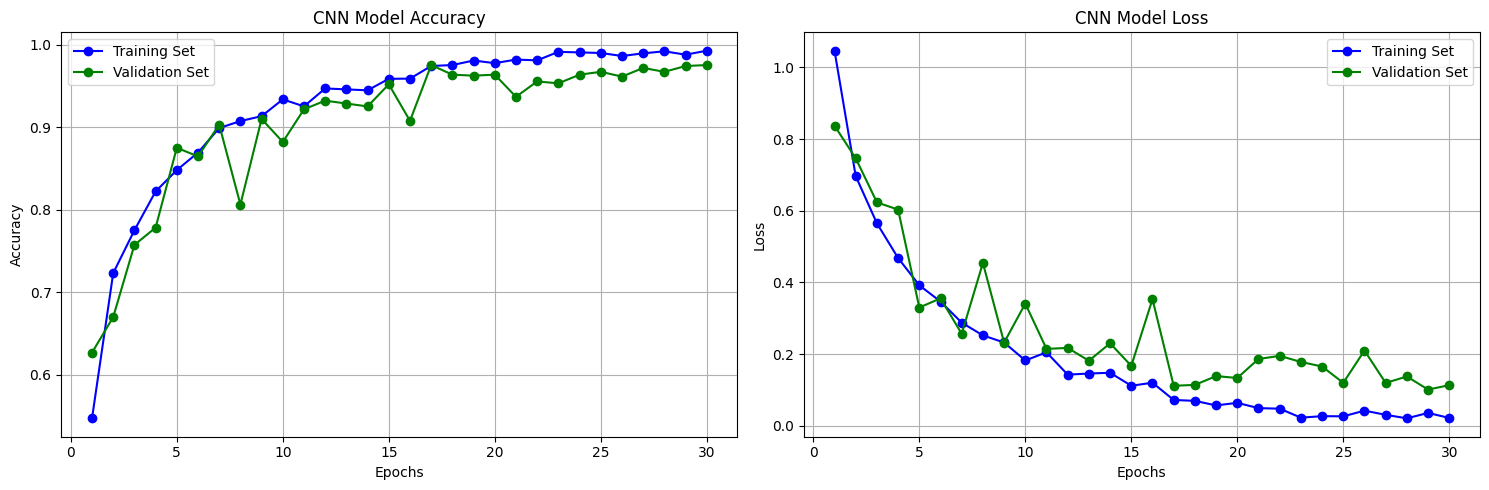

In [ ]:
# Plot model performance with enhanced aesthetics
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Set', marker='o', linestyle='-', color='b')
plt.plot(epochs_range, val_acc, label='Validation Set', marker='o', linestyle='-', color='g')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('CNN Model Accuracy')
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Set', marker='o', linestyle='-', color='b')
plt.plot(epochs_range, val_loss, label='Validation Set', marker='o', linestyle='-', color='g')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNN Model Loss')
plt.grid(True)

plt.tight_layout()
plt.show()

- Both training and validation accuracies are increasing, and the validation loss is decreasing
- The custom learning rate schedule is effective; it starts with 0.001 and is progressively reduced during training.


**7-2. confusion Matrix**

41/41 [==============================] - 1s 18ms/step


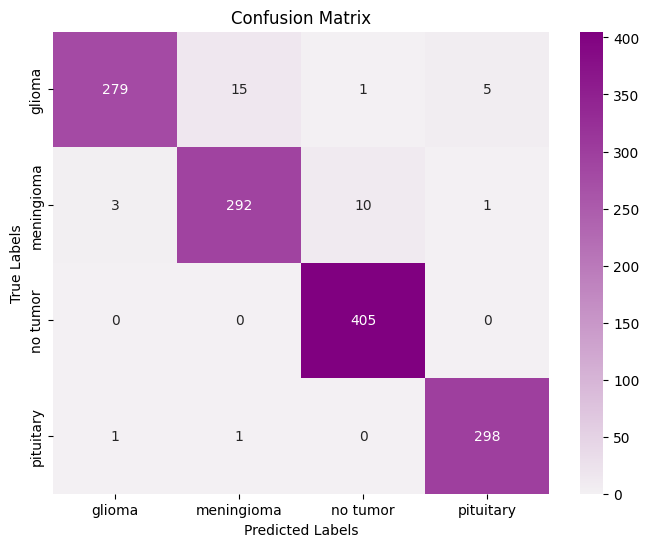

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'model' is your trained model and X_test, y_test are your test data
y_pred = np.argmax(model.predict(X_test), axis=1)

# Get the true labels
y_true = np.argmax(y_test, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Define a colormap
cmap = sns.light_palette("purple", as_cmap=True)

# Plot the confusion matrix with color
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=cmap,
            xticklabels=['glioma', 'meningioma', 'no tumor', 'pituitary'],
            yticklabels=['glioma', 'meningioma', 'no tumor', 'pituitary'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
